# Hate speech identification using neural network

The dataset in this notebook is from https://github.com/t-davidson/hate-speech-and-offensive-language

We're going to look at text classification, namely classifying whether tweets contain hate speech or offensive language.

I'm going to use neural network techniques here. There is also a notebook using simpler models, so we can compare both approaches regarding performance metrics and ease of implementation.

In [2]:
import pandas as pd

df = pd.read_csv('data/twitter-hate-speech.csv', index_col=0)

Data is loaded - let's have a quick look at what's in there?

In [3]:
df.head(n=10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


## Preprocessing

First we have to preprocess data and change the text of the tweets into something that can be used by a neural network model. Neural network models as i will use, need sequences of words (translated to unique IDs) as input. So that's what we'll create.

First step is cleaning and splitting the text into separate words. For cleaning we'll apply some simple tools from gensim and a custom function to remove twitter usernames (since we don't want the algorithm to memorize those).

In [4]:
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_punctuation, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
import re

RE_USERNAME = re.compile(r'@[a-z_]+', re.UNICODE)

def strip_usernames(s):
    return RE_USERNAME.sub('', s)

MY_FILTERS = [
    lambda x: x.lower(), strip_usernames, strip_punctuation, 
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
]

preprocessed = [preprocess_string(s, MY_FILTERS) for s in df['tweet']]

Let's have a look at the outcome of this! What words did we produce?

In [5]:
preprocessed[:3]

[['woman', 'shouldn', 'complain', 'cleaning', 'house', 'amp', 'man', 'trash'],
 ['boy',
  'dats',
  'cold',
  'tyga',
  'dwn',
  'bad',
  'cuffin',
  'dat',
  'hoe',
  'place'],
 ['dawg', 'sbabylife', 'fuck', 'bitch', 'start', 'confused', 'shit']]

Looks like the cleaning worked!

Next step is converting the words to unique IDs - we can use the gensim dictionary class for that. It can also filter out too (in-)frequent words.

In [7]:
from gensim.corpora import Dictionary

dictionary = Dictionary(preprocessed)
dictionary.filter_extremes(no_below=5, no_above=0.2)

sequences = [dictionary.doc2idx(x, unknown_word_index=0) for x in preprocessed]

The outcome of this step is lists of numbers, the token IDs:

In [8]:
sequences[:3]

[[7, 5, 2, 1, 3, 0, 4, 6],
 [9, 13, 10, 16, 0, 8, 11, 12, 14, 15],
 [18, 20, 19, 0, 22, 17, 21]]

The neural networks need sequences of fixed length as input. So we need to truncate or "pad" the sequences to correct length.

In [9]:
from keras.preprocessing.sequence import pad_sequences

MAXLEN = 20

padded = pad_sequences(sequences, MAXLEN)

Using TensorFlow backend.


Final preparation step is to create one list of labels. In the dataframe it's multiple columns to far, so we transform to the most likely category...

In [10]:
N_CLASS = 3
HATE = 2
OFFENSIVE = 1
NEUTRAL = 0

def determine_label(row):
    if row['hate_speech'] >= row['offensive_language'] and row['hate_speech'] > row['neither']:
        return HATE
    elif row['offensive_language'] >= row['hate_speech'] and row['offensive_language'] > row['neither']:
        return OFFENSIVE
    else:
        return NEUTRAL

labels = df.apply(determine_label, axis=1)

## Training data

so we're now done with data preparation and we can assign the training data!

In [11]:
from keras.utils import to_categorical

X = padded
y = to_categorical(labels, num_classes=N_CLASS)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Target variable / class imbalance

One thing that's important here - the distribution of the target variable. As you can see there is strong class imbalance, which (can) negatively impact the predictions.

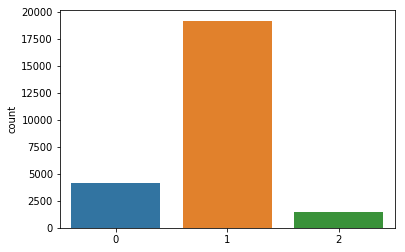

In [12]:
%matplotlib inline
import seaborn as sns

sns.countplot(labels)

What we can do to counteract the class imbalance is calculate appropriate penalties for prediction errors, the so-called class-weights:

In [13]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight('balanced', (NEUTRAL, OFFENSIVE, HATE), labels)

array([1.98438626, 0.43048463, 5.77692308])

## Defining the model

One popular type of model for NLP problems is an LSTM. It's intended to learn from sequence data, so it works well for text. Here we define the model:

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

def build_lstm_model():
    model = Sequential()
    model.add(Embedding(len(dictionary), 20, input_length=MAXLEN))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASS, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Training & learning curve

Now we can train our model from the training data and see what it learns. We'll use the X_train and y_train to learn from and the X_test and y_test to validate the model is indeed learning.

Splitting the data like that ensures the model learns generalizeable patterns and doesn't just memorize the training data...

In [17]:
model = build_lstm_model()

history = model.fit(X_train, y_train, batch_size=1000, epochs=20, validation_data=(X_test, y_test),
                    class_weight={0:5, 1:1, 2:20}, verbose=0)

Now i will plot the learning curve to verify the model indeed learns patterns.

What we'd like to see is an increase of accuracy on the training and validation data!

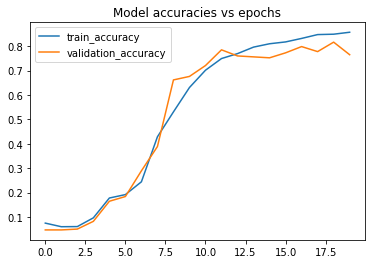

In [18]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame({
    'train_accuracy': history.history['acc'],
    'validation_accuracy': history.history['val_acc'],
})

df.plot(title='Model accuracies vs epochs')

## Evaluation

So with a trained model, let's see how well it performs? Let's evaluate!

I'm going to calculate the f1 scores and print the classification report to verify that it indeed learns and predicts something usefull for all categories:

In [67]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
                            target_names=('Neutral', 'Offensive', 'Hate')))

             precision    recall  f1-score   support

    Neutral       0.70      0.85      0.77       795
  Offensive       0.95      0.82      0.88      3928
       Hate       0.21      0.53      0.30       234

avg / total       0.87      0.81      0.84      4957



Looks like a reasonable start - we should attempt to do better on the HATE category but it's a reasonable start.

Compared to the logistic regression appraoch our model achies similar (even slightly better) performance. With more training data it should surpass the basic models. But even on such a small dataset it works well :-)